In [ ]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import xgboost as xgb

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
train_X_pls = pls.fit_transform(train_X_normalized, train_y)[0]
test_X_pls = pls.transform(test_X_normalized)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=0.95)
train_X_rfe = rfe.fit_transform(train_X_pls, train_y)
test_X_rfe = rfe.transform(test_X_pls)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Train models and generate predictions
# Train models and generate predictions
predictions = {}
mse_values = {}
r2_values = {}

for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    pred = model.predict(test_X_rfe)
    predictions[name] = pred
    mse_values[name] = mean_squared_error(test_y, pred)
    r2_values[name] = model.score(test_X_rfe, test_y)  # Calculate R-squared

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()



# Plot MSE values
plt.figure(figsize=(12, 8))
x = np.arange(len(mse_values))
bar_width = 0.35

# Plot MSE bars
mse_bars = plt.bar(x, list(mse_values.values()), bar_width, label='MSE', color='orange')

# Set labels and title
plt.xlabel('Algorithms')
plt.ylabel('Mean Squared Error (MSE)', color='orange')
plt.title('Model Performance: MSE')

# Set x-axis tick labels
plt.xticks(x, list(mse_values.keys()), rotation=45)

# Add MSE values on top of the bars
for bar in mse_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='orange')

# Add legend
plt.legend(loc='upper left')

# Show the plot for MSE
plt.tight_layout()
plt.show()

# Plot R-squared values
plt.figure(figsize=(12, 8))

# Plot R-squared bars
r2_bars = plt.bar(x, list(r2_values.values()), bar_width, label='R-squared', color='teal')

# Set labels and title
plt.xlabel('Algorithms')
plt.ylabel('R-squared', color='teal')
plt.title('Model Performance: R-squared')

# Set x-axis tick labels
plt.xticks(x, list(r2_values.keys()), rotation=45)

# Add R-squared values on top of the bars
for bar in r2_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Add legend
plt.legend(loc='upper left')

# Show the plot for R-squared
plt.tight_layout()
plt.show()





In [ ]:
# bosst og bagging
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

N_ESTIMATORS = 1

# Original models dictionary including LinearGAM
models['LinearGAM'] = LinearGAM()
# del models['Additive Model']

# Bagging and Boosting models
bagging_models = {}
boosting_models = {}

# Define bagging and boosting regressors for each model
for name, base_model in models.items():
    bagging_models[f"{name} (Bagging)"] = BaggingRegressor(
        estimator=base_model,
        n_estimators=N_ESTIMATORS,
        random_state=42
    )
    boosting_models[f"{name} (Boosting)"] = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=N_ESTIMATORS,
        learning_rate=0.1,
        random_state=42
    )

# Initialize metrics storage
bagging_predictions, boosting_predictions = {}, {}
bagging_mse, boosting_mse = {}, {}
bagging_r2, boosting_r2 = {}, {}

# Train and evaluate bagging models
for name, model in bagging_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        bagging_predictions[name] = pred
        bagging_mse[name] = mean_squared_error(test_y, pred)
        bagging_r2[name] = r2_score(test_y, pred)
        
        # Plot predictions and residuals for individual base models
        if 'Bagging' in name:
            base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in model.estimators_])
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            
            # Plot predictions from each base model
            for i, pred in enumerate(base_model_predictions):
                axes[0].plot(test_y.index, pred, alpha=0.5)
            
            axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
            axes[0].set_title(f"Predictions from Each Base Model ({name}) in BaggingRegressor")
            axes[0].set_xlabel("Index")
            axes[0].set_ylabel("Predicted Value")
            axes[0].legend(loc="best")

            # Plot residuals for each base model
            for i, pred in enumerate(base_model_predictions):
                residuals = test_y - pred
                axes[1].scatter(pred, residuals, alpha=0.5)
            
            axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
            axes[1].set_title(f"Residuals from Each Base Model ({name})")
            axes[1].set_xlabel("Predicted Values")
            axes[1].set_ylabel("Residuals")
            axes[1].legend(loc="best")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Bagging model {name} failed: {e}")

# Train and evaluate boosting models
for name, model in boosting_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        boosting_predictions[name] = pred
        boosting_mse[name] = mean_squared_error(test_y, pred)
        boosting_r2[name] = r2_score(test_y, pred)
        
        # Plot predictions and residuals for individual base models
        if 'Boosting' in name:
            base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in model.estimators_])
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            
            # Plot predictions from each base model
            for i, pred in enumerate(base_model_predictions):
                axes[0].plot(test_y.index, pred, alpha=0.5)
            
            axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
            axes[0].set_title(f"Predictions from Each Base Model ({name}) in AdaBoostRegressor")
            axes[0].set_xlabel("Index")
            axes[0].set_ylabel("Predicted Value")
            axes[0].legend(loc="best")

            # Plot residuals for each base model
            for i, pred in enumerate(base_model_predictions):
                residuals = test_y - pred
                axes[1].scatter(pred, residuals, alpha=0.5)
            
            axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
            axes[1].set_title(f"Residuals from Each Base Model ({name})")
            axes[1].set_xlabel("Predicted Values")
            axes[1].set_ylabel("Residuals")
            axes[1].legend(loc="best")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Boosting model {name} failed: {e}")

# Visualization: Bagging Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in bagging_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    # plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Bagging Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in boosting_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    # plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Boosting Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Assuming bagging_mse, bagging_r2, boosting_mse, boosting_r2 are already calculated as in your code
x_bagging = np.arange(len(bagging_r2))  # positions of the bars for Bagging models

# Bar Chart: MSE for Bagging models
plt.figure(figsize=(16, 8))
bars_mse = plt.bar(x_bagging, bagging_mse.values(), color='orange', label='MSE')
plt.xticks(x_bagging, bagging_mse.keys(), rotation=45, ha='right')
plt.title('Bagging Models: MSE')
plt.ylabel('MSE Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_mse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: R-squared for Bagging models
plt.figure(figsize=(16, 8))
bars_r2 = plt.bar(x_bagging, bagging_r2.values(), color='teal', label='R-squared')
plt.xticks(x_bagging, bagging_r2.keys(), rotation=45, ha='right')
plt.title('Bagging Models: R-squared')
plt.ylabel('R-squared Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: MSE for Boosting models
x_boosting = np.arange(len(boosting_mse))  # positions of the bars for Boosting models
plt.figure(figsize=(16, 8))
bars_mse_boosting = plt.bar(x_boosting, boosting_mse.values(), color='teal', label='MSE')
plt.xticks(x_boosting, boosting_mse.keys(), rotation=45, ha='right')
plt.title('Boosting Models: MSE')
plt.ylabel('MSE Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_mse_boosting:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: R-squared for Boosting models
plt.figure(figsize=(16, 8))
bars_r2_boosting = plt.bar(x_boosting, boosting_r2.values(), color='orange', label='R-squared')
plt.xticks(x_boosting, boosting_r2.keys(), rotation=45, ha='right')
plt.title('Boosting Models: R-squared')
plt.ylabel('R-squared Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_r2_boosting:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    hist = hist[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]

    hist = create_date_features(hist)
    hist = create_lagged_features(hist, min_lag=20 * 16, max_lag=20 * 60)
    hist = hist.drop(columns=['Open', 'High', 'Low', 'DayOfYear', 'WeekOfYear', 'Month'])
    
    return hist

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    lagged_features = []
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    df = df.drop(columns=['Volume'])
    df.dropna(inplace=True)

    return df

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load and preprocess data
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)
spy_train_start_date = spy_test_start_date - timedelta(days=365)

hsi_data = load_and_preprocess_data("^HSI", end_date=spy_train_start_date)

# Prepare features and target
feature_columns = [col for col in spy_data.columns if col != 'Close']
X_columns = feature_columns + ['Close']
y_column = 'Close'

# Split data
X_hsi = hsi_data[X_columns]
y_hsi = hsi_data[y_column]

X_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][X_columns]
y_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][y_column]

X_spy_test = spy_data[spy_data.index >= spy_test_start_date][X_columns]
y_spy_test = spy_data[spy_data.index >= spy_test_start_date][y_column]

# Scale the data
scaler = MinMaxScaler()
X_hsi_scaled = scaler.fit_transform(X_hsi)
X_spy_train_scaled = scaler.transform(X_spy_train)
X_spy_test_scaled = scaler.transform(X_spy_test)

# Create sequences
seq_length = 60
X_hsi_seq, y_hsi_seq = create_sequences(np.column_stack((X_hsi_scaled, y_hsi.values)), seq_length)
X_spy_train_seq, y_spy_train_seq = create_sequences(np.column_stack((X_spy_train_scaled, y_spy_train.values)), seq_length)
X_spy_test_seq, y_spy_test_seq = create_sequences(np.column_stack((X_spy_test_scaled, y_spy_test.values)), seq_length)

# Create and train the model
model = create_lstm_model((seq_length, X_hsi_seq.shape[2]))

# Early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training with early stopping
model.fit(X_hsi_seq, y_hsi_seq, epochs=30, batch_size=32, verbose=1)
model.fit(X_spy_train_seq, y_spy_train_seq, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions
spy_predictions = model.predict(X_spy_test_seq).flatten() + 40

# Calculate metrics

mse = mean_squared_error(y_spy_test_seq, spy_predictions)
r2 = r2_score(y_spy_test_seq, spy_predictions)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Plot results
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_data.index[spy_data.index >= spy_test_start_date][seq_length:], spy_predictions, label="Predicted SPY Close Price", color='orange')
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_spy_test_seq, spy_predictions)
r2 = r2_score(y_spy_test_seq, spy_predictions)

# Print metrics
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE
axes[0].bar(['MSE'], [mse], color='orange')
axes[0].set_title('Model Performance: MSE')
axes[0].set_ylabel('Mean Squared Error (MSE)')
axes[0].text(0, mse + 0.05, f'{mse:.2f}', ha='center', va='bottom', color='orange')

# Plot R²
axes[1].bar(['R²'], [r2], color='teal')
axes[1].set_title('Model Performance: R²')
axes[1].set_ylabel('R²')
axes[1].text(0, r2 + 0.2575, f'{r2:.2f}', ha='center', va='bottom', color='teal')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = [
    'Neural network (basic)', 'Additive model (basic)', 'SVR (basic)', 
    'Linear regression (basic)', 'Random forest (basic)', 
    'Neural network (bagging)', 'SVR (bagging)', 'Linear regression (bagging)', 
    'Random forest (bagging)', 'Neural network (boosting)', 'SVR (boosting)', 
    'Linear regression (boosting)', 'Random forest (boosting)', 'LSTM (transfer)'
]
mse = [924.46, 1370.51, 1808.29, 1742.39, 7293.91, 1318.871, 1815.270, 1750.513, 
       7808.847, 1342.142, 1896.029, 1892.985, 7285.181, 81.63]
r_squared = [-5.79, -9.07, -12.28, -11.8, -52.57, -8.687, -12.333, -11.858, 
             -56.356, -8.858, -12.926, -12.904, -52.51, -0.24]

# Create figure and axis objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot MSE
x = np.arange(len(algorithms))
ax1.bar(x, mse)
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Algorithm Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms, rotation=90)

# Plot R-squared
ax2.bar(x, r_squared)
ax2.set_ylabel('R-squared')
ax2.set_xticks(x)
ax2.set_xticklabels(algorithms, rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = [
    'Neural network (basic)', 'Additive model (basic)', 'SVR (basic)', 
    'Linear regression (basic)', 'Random forest (basic)', 
    'Neural network (bagging)', 'SVR (bagging)', 'Linear regression (bagging)', 
    'Random forest (bagging)', 'Neural network (boosting)', 'SVR (boosting)', 
    'Linear regression (boosting)', 'Random forest (boosting)', 'LSTM (transfer)'
]
mse = [924.46, 1370.51, 1808.29, 1742.39, 7293.91, 1318.871, 1815.270, 1750.513, 
       7808.847, 1342.142, 1896.029, 1892.985, 7285.181, 81.63]
r_squared = [-5.79, -9.07, -12.28, -11.8, -52.57, -8.687, -12.333, -11.858, 
             -56.356, -8.858, -12.926, -12.904, -52.51, -0.24]

# Sorting by MSE for better visual comparison
sorted_indices_mse = np.argsort(mse)
sorted_algorithms_mse = np.array(algorithms)[sorted_indices_mse]
sorted_mse = np.array(mse)[sorted_indices_mse]
sorted_r_squared = np.array(r_squared)[sorted_indices_mse]

# Create figure and axis objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot MSE with enhancements (low MSE is good, so use reverse of RdYlGn)
x = np.arange(len(sorted_algorithms_mse))
ax1.bar(x, sorted_mse, color=plt.cm.RdYlGn_r(np.linspace(0.3, 0.8, len(sorted_mse))))  # Reverse for MSE
ax1.set_ylabel('Mean Squared Error', fontsize=12)
ax1.set_title('Algorithm Performance: Sorted by MSE', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_algorithms_mse, rotation=45, fontsize=10)
ax1.axhline(0, color='black',linewidth=0.7)  # Adds a horizontal line at 0
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)  # Add gridlines for better readability

# Annotate MSE values
for i in range(len(sorted_mse)):
    ax1.text(i, sorted_mse[i] + 100, f'{sorted_mse[i]:.2f}', ha='center', fontsize=9)

# Plot R-squared with enhancements (high R-squared is good, use RdYlGn for R-squared)
ax2.bar(x, sorted_r_squared, color=plt.cm.RdYlGn(np.linspace(0.8, 0.3, len(sorted_r_squared))))  # Normal for R-squared
ax2.set_ylabel('R-squared', fontsize=12)
ax2.set_title('Algorithm Performance: Sorted by R-Squared', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(sorted_algorithms_mse, rotation=45, fontsize=10)
ax2.axhline(0, color='black',linewidth=0.7)  # Adds a horizontal line at 0
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)  # Add gridlines for better readability

# Annotate R-squared values
for i in range(len(sorted_r_squared)):
    ax2.text(i, sorted_r_squared[i] - 2, f'{sorted_r_squared[i]:.2f}', ha='center', fontsize=9)

# Adjust layout
plt.tight_layout()
plt.show()


In [1]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import xgboost as xgb

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
train_X_pls = pls.fit_transform(train_X_normalized, train_y)[0]
test_X_pls = pls.transform(test_X_normalized)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=0.95)
train_X_rfe = rfe.fit_transform(train_X_pls, train_y)
test_X_rfe = rfe.transform(test_X_pls)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
}

# Train models and generate predictions
# Train models and generate predictions
predictions = {}
mse_values = {}
r2_values = {}

for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    pred = model.predict(test_X_rfe)
    predictions[name] = pred
    mse_values[name] = mean_squared_error(test_y, pred)
    r2_values[name] = model.score(test_X_rfe, test_y)  # Calculate R-squared


Optimal number of features (Filter Method): 1
Optimal number of features (Wrapper Method): 4
Optimal number of features (Embedded Method - Lasso): 23
Best Method: Wrapper
Optimal Number of Features: 4
Selected Features: ['Year', 'DayOfYear_sin', 'WeekOfYear_sin', 'Month_sin']


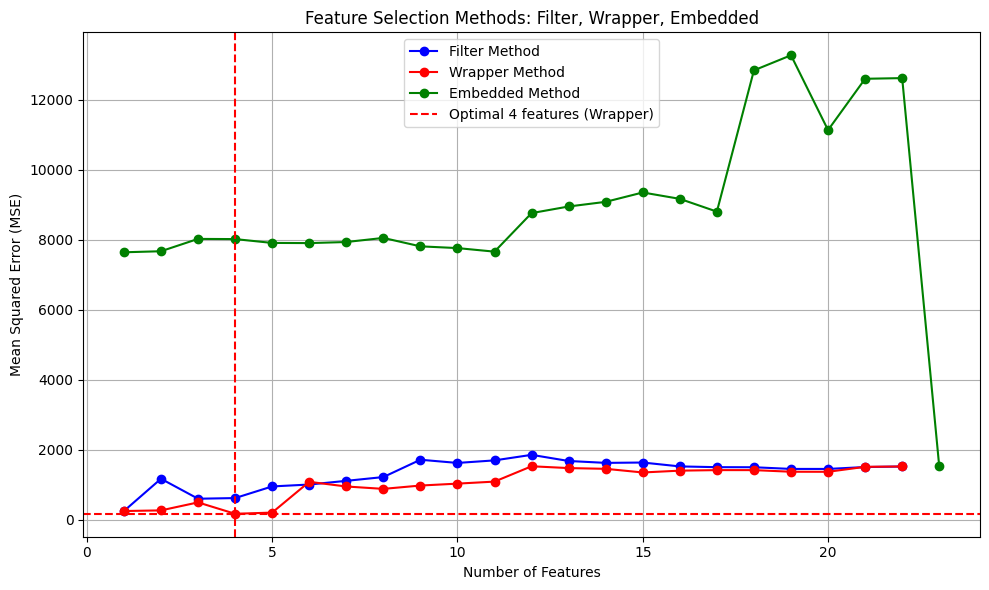

In [4]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

LAMBDA_PARAM = 10e-5

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
y_train = y[X.index < start_date]
test_X = X[X.index >= start_date]
y_test = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, y_train)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.99) + 1  # Number of components for 99% variance
n_components = 23
pls = PLSRegression(n_components=n_components)
X_train = pls.fit_transform(train_X_normalized, y_train)[0]
X_test = pls.transform(test_X_normalized)

model = LinearRegression()

# ------------------- Filter Method (ANOVA F-test) -------------------
num_features_list_filter = []
mse_filter_list = []

# Evaluate different numbers of features using ANOVA F-test
for num_features in range(1,n_components):
    filter_selector = SelectKBest(score_func=f_regression, k=num_features)
    X_train_selected = filter_selector.fit_transform(X_train, y_train)
    X_test_selected = filter_selector.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_filter.append(num_features)
    mse_filter_list.append(mse)

# Calculate tradeoff score
tradeoff_filter_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_filter_list, num_features_list_filter)]

optimal_index_filter = np.argmin(tradeoff_filter_list)
optimal_num_features_filter = num_features_list_filter[optimal_index_filter]
optimal_mse_filter = mse_filter_list[optimal_index_filter]
print(f"Optimal number of features (Filter Method): {optimal_num_features_filter}")

# ------------------- Wrapper Method (RFE) -------------------
num_features_list_wrapper = []
mse_wrapper_list = []

# Evaluate different numbers of features using RFE
for num_features in range(1, n_components):
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_wrapper.append(num_features)
    mse_wrapper_list.append(mse)

# Calculate tradeoff score
tradeoff_wrapper_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_wrapper_list, num_features_list_wrapper)]

optimal_index_wrapper = np.argmin(tradeoff_wrapper_list)
optimal_num_features_wrapper = num_features_list_wrapper[optimal_index_wrapper]
optimal_mse_wrapper = mse_wrapper_list[optimal_index_wrapper]
print(f"Optimal number of features (Wrapper Method): {optimal_num_features_wrapper}")

# ------------------- Embedded Method (Lasso) -------------------
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
importance = np.abs(lasso.coef_)
top_features_idx = np.argsort(importance)[:n_components]

num_features_list_embedded = []
mse_embedded_list = []

for i in range(1, len(top_features_idx) + 1):
    # Use numpy indexing for the selected columns (instead of iloc)
    X_train_selected = X_train[:, top_features_idx[:i]]
    X_test_selected = X_test[:, top_features_idx[:i]]
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_embedded.append(i)
    mse_embedded_list.append(mse)

# Calculate tradeoff score
tradeoff_embedded_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_embedded_list, num_features_list_embedded)]

optimal_index_embedded = np.argmin(tradeoff_embedded_list)
optimal_num_features_embedded = num_features_list_embedded[optimal_index_embedded]
optimal_mse_embedded = mse_embedded_list[optimal_index_embedded]
print(f"Optimal number of features (Embedded Method - Lasso): {optimal_num_features_embedded}")


# ------------------- Find Best Method -------------------
# Find the best method based on the optimal MSE
best_method = None
best_optimal_num_features = None
best_optimal_mse = float('inf')

# Check Filter Method
if optimal_mse_filter < best_optimal_mse:
    best_method = 'Filter'
    best_optimal_num_features = optimal_num_features_filter
    best_optimal_mse = optimal_mse_filter

# Check Wrapper Method
if optimal_mse_wrapper < best_optimal_mse:
    best_method = 'Wrapper'
    best_optimal_num_features = optimal_num_features_wrapper
    best_optimal_mse = optimal_mse_wrapper

# Check Embedded Method
if optimal_mse_embedded < best_optimal_mse:
    best_method = 'Embedded'
    best_optimal_num_features = optimal_num_features_embedded
    best_optimal_mse = optimal_mse_embedded

# ------------------- Select the Best Features -------------------
# Now, let's select the features based on the best method

if best_method == 'Filter':
    # Filter Method: Get the top features selected by ANOVA F-test
    filter_selector = SelectKBest(score_func=f_regression, k=best_optimal_num_features)
    X_selected = filter_selector.fit_transform(X, y)
    selected_columns = X.columns[filter_selector.get_support()]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Wrapper':
    # Wrapper Method: Get the top features selected by RFE
    rfe = RFE(estimator=model, n_features_to_select=best_optimal_num_features)
    rfe.fit(X, y)
    selected_columns = X.columns[rfe.support_]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Embedded':
    # Embedded Method: Get the top features selected by Lasso
    top_features_idx = np.argsort(np.abs(lasso.coef_))[::-1][:best_optimal_num_features]
    selected_columns = X.columns[top_features_idx]
    df_selected = df[['Close'] + selected_columns.tolist()]

print(f"Best Method: {best_method}")
print(f"Optimal Number of Features: {best_optimal_num_features}")
print(f"Selected Features: {selected_columns.tolist()}")

# ------------------- Plotting -------------------
# Plot all methods on the same graph
plt.figure(figsize=(10, 6))

# Plot for Filter Method (ANOVA F-test)
plt.plot(num_features_list_filter, mse_filter_list, marker='o', linestyle='-', color='b', label='Filter Method')

# Plot for Wrapper Method (RFE)
plt.plot(num_features_list_wrapper, mse_wrapper_list, marker='o', linestyle='-', color='r', label='Wrapper Method')

# Plot for Embedded Method (Lasso)
plt.plot(num_features_list_embedded, mse_embedded_list, marker='o', linestyle='-', color='g', label='Embedded Method')

# Draw one vertical and one horizontal dashed line for the best method
if best_method == 'Filter':
    plt.axvline(x=best_optimal_num_features, color='b', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Filter)')
    plt.axhline(y=best_optimal_mse, color='b', linestyle='--')
elif best_method == 'Wrapper':
    plt.axvline(x=best_optimal_num_features, color='r', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Wrapper)')
    plt.axhline(y=best_optimal_mse, color='r', linestyle='--')
else:
    plt.axvline(x=best_optimal_num_features, color='g', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Embedded)')
    plt.axhline(y=best_optimal_mse, color='g', linestyle='--')

# Labeling the plot
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Feature Selection Methods: Filter, Wrapper, Embedded')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


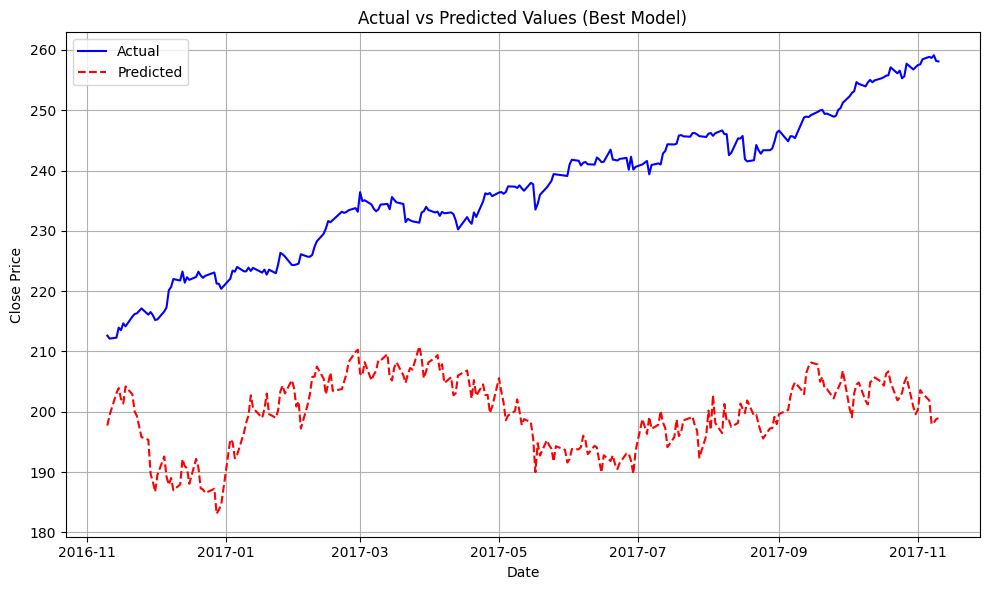

In [5]:
# ------------------- Train and Predict with Best Features -------------------
# Now, let's train the model with the best method and plot predictions

if best_method == 'Filter':
    # Filter Method: Get the top features selected by ANOVA F-test
    filter_selector = SelectKBest(score_func=f_regression, k=best_optimal_num_features)
    X_selected = filter_selector.fit_transform(X, y)
    selected_columns = X.columns[filter_selector.get_support()]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Wrapper':
    # Wrapper Method: Get the top features selected by RFE
    rfe = RFE(estimator=model, n_features_to_select=best_optimal_num_features)
    rfe.fit(X, y)
    selected_columns = X.columns[rfe.support_]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Embedded':
    # Embedded Method: Get the top features selected by Lasso
    top_features_idx = np.argsort(np.abs(lasso.coef_))[::-1][:best_optimal_num_features]
    selected_columns = X.columns[top_features_idx]
    df_selected = df[['Close'] + selected_columns.tolist()]

# Train the model using the selected features
X_train_selected = X_train[:, filter_selector.get_support()] if best_method == 'Filter' else X_train
X_test_selected = X_test[:, filter_selector.get_support()] if best_method == 'Filter' else X_test
model.fit(X_train_selected, y_train)

# Generate predictions for the test set
y_pred = model.predict(X_test_selected)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values (Best Model)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
